# CheXagent disease classification on [NIH Chest X-ray data](https://www.kaggle.com/datasets/nih-chest-xrays/sample/data)


###### Imports


In [1]:
import csv
import io
import json
import warnings
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
import torch
from PIL import Image
from rich import print
from tqdm.notebook import tqdm
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

###### Function definitions


In [2]:
def download_image(url):
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(io.BytesIO(resp.content)).convert("RGB")


def generate(images, prompt, processor, model, device, dtype, generation_config):
    inputs = processor(images=images[:2], text=f" USER: <s>{prompt} ASSISTANT: <s>", return_tensors="pt").to(
        device=device, dtype=dtype
    )
    output = model.generate(
        **inputs,
        generation_config=generation_config,
        # this silences "Setting `pad_token_id` to `eos_token_id`:{eos_token_id} for open-end generation."
        pad_token_id=processor.tokenizer.eos_token_id,
    )[0]
    response = processor.tokenizer.decode(output, skip_special_tokens=True)
    return response


def plot_img(image, title):
    plt.imshow(image)
    plt.axis("off")
    plt.title(title)
    plt.show()


def get_num_findings(string):
    if string == "No Finding":
        return 1
    else:
        return string.count(")")


def count_substrings(input_string):
    substrings = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax", "No Finding"]  # fmt: skip # nopep8

    cumulative_count = 0
    for substring in substrings:
        cumulative_count += input_string.count(substring)

    return cumulative_count


def is_label_in_response(series):
    if series["finding_labels"] in series["response"]:
        return True
    else:
        return False


def is_true_positive(series):
    if series["label_in_response"] and (series["response_num_findings"] == 1):
        return True
    else:
        return False


def disp_df(dataframe):
    display(dataframe.head())
    print(f"nRows: {dataframe.shape[0]:,}\tnColumns: {dataframe.shape[1]}")

## NIH Chest X-ray dataset


###### Load dataset


In [3]:
column_names = ["image_index", "finding_labels", "follow_up_number", "patient_id", "patient_age", "patient_gender", "view_position", "original_image_width", "original_image_height", "original_image_pixel_spacing_x", "original_image_pixel_spacing_y"]  # fmt: skip # nopep8

data = pd.read_csv(
    "./data/NIH_Chest_X-ray_Dataset/Data_Entry_2017.csv",
    names=column_names,
    header=0,
    index_col=False,
)
display(data.head())
print(f"Rows: {data.shape[0]:,}\tColumns: {data.shape[1]}")
print(f"Number of patients: {data['patient_id'].nunique():,}")

,image_index,finding_labels,follow_up_number,patient_id,patient_age,patient_gender,view_position,original_image_width,original_image_height,original_image_pixel_spacing_x,original_image_pixel_spacing_y
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


Rows: 112,120   Columns: 11

Number of patients: 30,805

###### Visualize data


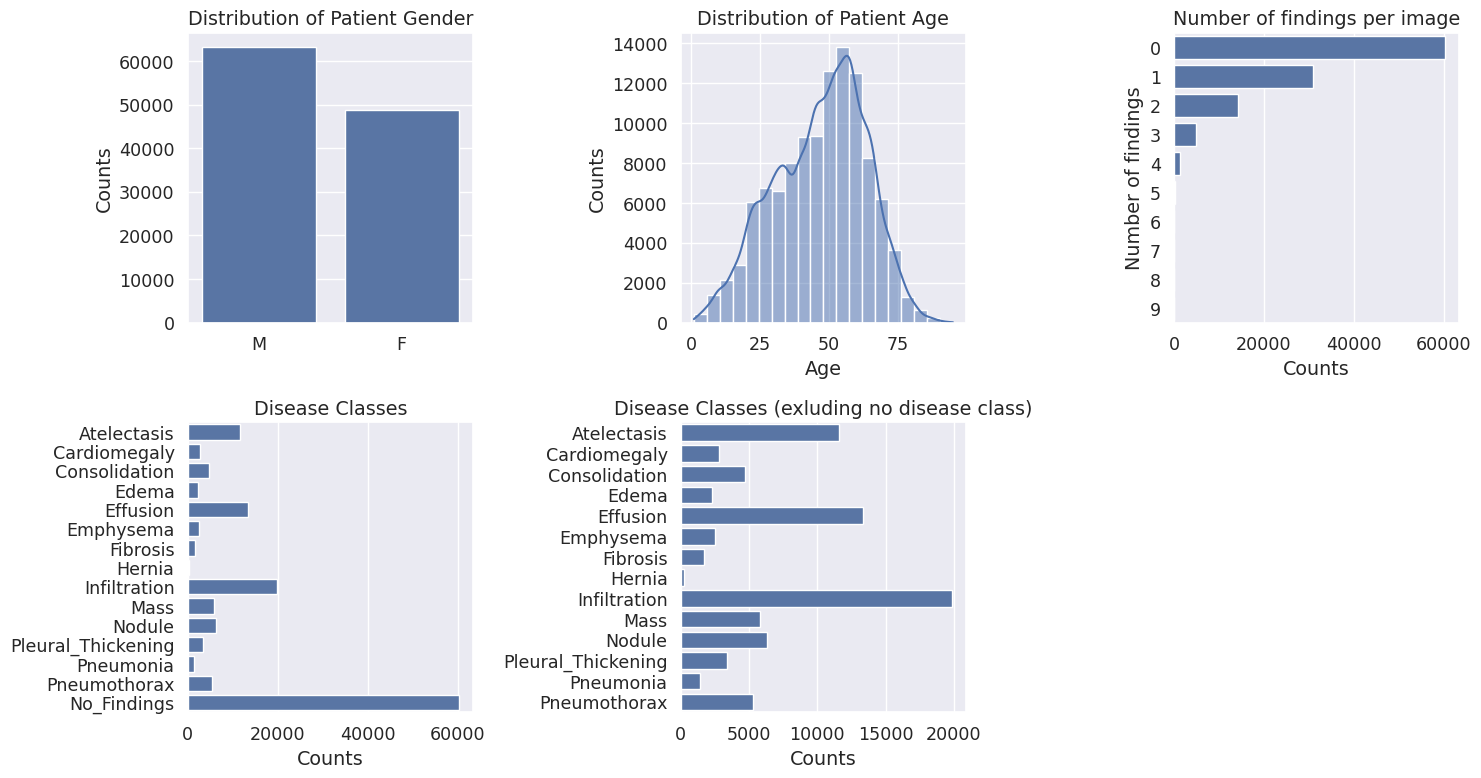

In [4]:
GOLDEN = (1 + 5**0.5) / 2
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
sns.countplot(x=data["patient_gender"])
plt.gca().set(title="Distribution of Patient Gender", xlabel=None, ylabel="Counts")

plt.subplot(2, 3, 2)
sns.histplot(data=data[data["patient_age"] < 130], x="patient_age", bins=20, kde=True)
plt.gca().set(title="Distribution of Patient Age", xlabel="Age", ylabel="Counts")

# Create boolean columns for each pathology type
pathology_list = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]  # fmt: skip # nopep8
for pathology in pathology_list:
    data[pathology] = data["finding_labels"].apply(lambda x: 1 if pathology in x else 0)

data["No_Findings"] = data["finding_labels"].apply(lambda x: 1 if "No Finding" in x else 0)

plt.subplot(2, 3, 3)
sns.barplot(data.iloc[:, 11:-1].sum(axis=1).value_counts(), orient="h")
plt.gca().set(title="Number of findings per image", xlabel="Counts", ylabel="Number of findings")

# Sum of values across selected columns and reset index for Seaborn
sum_data = data.iloc[:, 11:].sum().reset_index()
sum_data.columns = ["Feature", "Total"]

plt.subplot(2, 3, 4)
sns.barplot(x="Total", y="Feature", data=sum_data)
plt.gca().set(title="Disease Classes", xlabel="Counts", ylabel=None)

plt.subplot(2, 3, 5)
sns.barplot(x="Total", y="Feature", data=sum_data.loc[sum_data["Feature"] != "No_Findings", :])
plt.gca().set(title="Disease Classes (exluding no disease class)", xlabel="Counts", ylabel=None)
plt.tight_layout()
plt.show()

###### remove calculated columns


In [5]:
data = data[column_names]

## Using CheXagent


###### CheXagent: Load Processor and Model


In [6]:
# device = "cuda"
# dtype = torch.float16

# processor = AutoProcessor.from_pretrained("StanfordAIMI/CheXagent-8b", trust_remote_code=True)
# generation_config = GenerationConfig.from_pretrained("StanfordAIMI/CheXagent-8b")
# model = AutoModelForCausalLM.from_pretrained("StanfordAIMI/CheXagent-8b", torch_dtype=dtype, trust_remote_code=True).to(
#     device
# )

###### Apply CheXagent on single image


In [7]:
# # subset: cases with exactly one finding label, first case of each label
# subset = data.loc[(data["finding_labels"].str.count("\\|") + 1) == 1, :].sample(1)

# image_dir = "./data/NIH_Chest_X-ray_Dataset"
# image_path = next(Path(image_dir).rglob(subset["image_index"].values[0])).as_posix()
# image = Image.open(image_path).convert("RGB")

# img_name, label = subset["image_index"].values[0], subset["finding_labels"].values[0]
# plot_title = f"Label: {label} ({img_name})"
# plot_img(image, plot_title)

# prompt = """
# From the following list of findings, identify which finding is present in the this chest X-ray:
# 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'.
# If no findings are present, respond by stating 'No Finding'.
# """

# warnings.filterwarnings("ignore", category=UserWarning)
# response = generate([image], prompt, processor, model, device, dtype, generation_config)
# warnings.resetwarnings()

# print(f"Correct finding: {subset['finding_labels'].values[0]}")
# print(f"CheXagent response: {response}")

### Prompt engineering for disease classification


###### Define prompts


In [8]:
# # fmt: off
# prompts = {}
# prompts["1"] = """From the following list of findings, identify which finding is present in the this chest X-ray:
# 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'.
# If no findings are present, respond by stating 'No Finding'."""
# prompts["2"] = """Which finding is in this chest X-ray: A) 'Atelectasis', B) 'Cardiomegaly', C) 'Consolidation', D) 'Edema', E) 'Effusion', F) 'Emphysema', G) 'Fibrosis', H) 'Hernia', I) 'Infiltration', J) 'Mass', K) 'Nodule', L) 'Pleural_Thickening', M) 'Pneumonia', N) 'Pneumothorax', or O) 'No Finding'."""
# prompts["3"] = """Which single finding is in this chest X-ray: A) 'Atelectasis', B) 'Cardiomegaly', C) 'Consolidation', D) 'Edema', E) 'Effusion', F) 'Emphysema', G) 'Fibrosis', H) 'Hernia', I) 'Infiltration', J) 'Mass', K) 'Nodule', L) 'Pleural_Thickening', M) 'Pneumonia', N) 'Pneumothorax', or O) 'No Finding'."""
# prompts["4"] = """A single finding is present in the given chest X-ray. Identify the finding by selecting one option from the following list: A) 'Atelectasis', B) 'Cardiomegaly', C) 'Consolidation', D) 'Edema', E) 'Effusion', F) 'Emphysema', G) 'Fibrosis', H) 'Hernia', I) 'Infiltration', J) 'Mass', K) 'Nodule', L) 'Pleural_Thickening', M) 'Pneumonia', N) 'Pneumothorax', or O) 'No Finding'. Do not select muliple findings."""
# prompts["5"] = """This chest X-ray has exacltly one disease condition. Identify the correct disease condition from the following options: A) 'Atelectasis', B) 'Cardiomegaly', C) 'Consolidation', D) 'Edema', E) 'Effusion', F) 'Emphysema', G) 'Fibrosis', H) 'Hernia', I) 'Infiltration', J) 'Mass', K) 'Nodule', L) 'Pleural_Thickening', M) 'Pneumonia', N) 'Pneumothorax', or O) 'No Finding'."""
# prompts["6"] = """This chest X-ray has exacltly one disease condition. The correct disease condition is found in the following list: A) 'Atelectasis', B) 'Cardiomegaly', C) 'Consolidation', D) 'Edema', E) 'Effusion', F) 'Emphysema', G) 'Fibrosis', H) 'Hernia', I) 'Infiltration', J) 'Mass', K) 'Nodule', L) 'Pleural_Thickening', M) 'Pneumonia', N) 'Pneumothorax', O) 'No Finding'. What is the correct disease condition?"""
# prompts["7"] = """This chest X-ray has exacltly one disease condition. The correct disease condition is found in the following list:
#     A) 'Atelectasis'
#     B) 'Cardiomegaly'
#     C) 'Consolidation'
#     D) 'Edema'
#     E) 'Effusion'
#     F) 'Emphysema'
#     G) 'Fibrosis'
#     H) 'Hernia'
#     I) 'Infiltration'
#     J) 'Mass'
#     K) 'Nodule'
#     L) 'Pleural_Thickening'
#     M) 'Pneumonia'
#     N) 'Pneumothorax'
#     O) 'No Finding'
# What is the correct disease condition?"""
# prompts["8"] = """This chest X-ray has exacltly one disease condition. The correct disease condition is found in the following list:
#     A) Atelectasis
#     B) Cardiomegaly
#     C) Consolidation
#     D) Edema
#     E) Effusion
#     F) Emphysema
#     G) Fibrosis
#     H) Hernia
#     I) Infiltration
#     J) Mass
#     K) Nodule
#     L) Pleural_Thickening
#     M) Pneumonia
#     N) Pneumothorax
#     O) No Finding
# What is the correct disease condition?"""
# prompts["9"] = """A single finding is present in the given chest X-ray. Identify the finding by selecting one option from the following list:
#     A) 'Atelectasis'
#     B) 'Cardiomegaly'
#     C) 'Consolidation'
#     D) 'Edema'
#     E) 'Effusion'
#     F) 'Emphysema'
#     G) 'Fibrosis'
#     H) 'Hernia'
#     I) 'Infiltration'
#     J) 'Mass'
#     K) 'Nodule'
#     L) 'Pleural_Thickening'
#     M) 'Pneumonia'
#     N) 'Pneumothorax'
#     O) 'No Finding'
# Do not select muliple findings."""
# prompts["10"] = """A single finding is present in the given chest X-ray. Identify the finding by selecting one option from the following list:
#     A) Atelectasis
#     B) Cardiomegaly
#     C) Consolidation
#     D) Edema
#     E) Effusion
#     F) Emphysema
#     G) Fibrosis
#     H) Hernia
#     I) Infiltration
#     J) Mass
#     K) Nodule
#     L) Pleural_Thickening
#     M) Pneumonia
#     N) Pneumothorax
#     O) No Finding
# Do not select muliple findings."""
# # fmt: on

In [9]:
# # import prompts dictionary
# with open("data/prompts.json", "r") as json_file:
#     prompts = json.load(json_file)

# # export prompts dictionary
# # with open("data/prompts.json", "w") as json_file:
# # json.dump(prompts, json_file, indent=4)

#### Prepare input data for CheXagent


###### NIH Chest X-ray dataset: single finding cases with prompt_key column


In [10]:
# data_single_finding = data.loc[
#     (data["finding_labels"].str.count("\\|") + 1) == 1, ["image_index", "finding_labels"]
# ].copy()
# data_single_finding_prompts = pd.DataFrame()
# for prompt_key in prompts.keys():
#     df_i = data_single_finding.copy()
#     df_i["prompt_key"] = prompt_key
#     data_single_finding_prompts = pd.concat([data_single_finding_prompts, df_i])

# disp_df(data_single_finding_prompts)

###### Load analyzed image/prompt combinations


In [11]:
# filelist = [x.as_posix() for x in Path("output").glob("disease_classification_QA*.csv")]

# df_results_prev = pd.DataFrame()
# for f in filelist:
#     df_i = pd.read_csv(f, usecols=["image_index", "finding_labels", "prompt_key", "response"], dtype=str)
#     df_results_prev = pd.concat([df_results_prev, df_i])

# df_results_prev = df_results_prev.drop_duplicates(ignore_index=True)
# disp_df(df_results_prev)

###### Input image/prompt combinations that have not been analyzed


In [12]:
# df_not_analyzed = pd.merge(left=data_single_finding_prompts, right=df_results_prev, how="left").pipe(
#     lambda x: x.loc[x["response"].isna(), ["image_index", "finding_labels", "prompt_key"]]
# )

# disp_df(df_not_analyzed)

###### sort the input dataframe


In [13]:
# # show least analyzed finding_label first
# count_map = df_results_prev["finding_labels"].value_counts().to_dict()
# df_not_analyzed["label_count"] = df_not_analyzed["finding_labels"].map(count_map)

# # create int dtype of prompt key column
# df_not_analyzed["prompt_key_int"] = df_not_analyzed["prompt_key"].astype(int)

# df_not_analyzed = df_not_analyzed.sort_values(["label_count", "image_index", "prompt_key_int"], ignore_index=True).drop(
#     columns=["label_count", "prompt_key_int"]
# )
# disp_df(df_not_analyzed)

###### add image filepaths


In [14]:
# # import filepaths
# df_full_paths = (
#     pd.read_csv("./output/single_finding_datalist.csv", usecols=["image_index", "image_path"])
#     .set_index("image_index")["image_path"]
#     .to_dict()
# )

# df_not_analyzed["image_path"] = df_not_analyzed["image_index"].map(df_full_paths)

# disp_df(df_not_analyzed)

#### Apply CheXagent on NIH dataset using `prompts`


In [15]:
# now = datetime.now()
# datetime_str = now.strftime("%Y%m%d_%H%M%S")
# csv_file_path = f"output/disease_classification_QA_{datetime_str}.csv"

# warnings.filterwarnings("ignore", category=UserWarning)

# with open(csv_file_path, mode="w", newline="") as file:
#     writer = csv.writer(file)
#     writer.writerow(["image_index", "finding_labels", "prompt", "prompt_key", "response"])

#     for _, row in tqdm(subset.iterrows(), total=subset.shape[0], desc="Processing images"):
#         images = [Image.open(row["image_path"]).convert("RGB")]
#         img_name, label = row["image_index"], row["finding_labels"]
#         title = f"Label: {label} ({img_name})"
#         for prompt_key, prompt in prompts.items():
#             response = generate(images, prompt, processor, model, device, dtype, generation_config)
#             row_data = [img_name, label, prompt, prompt_key, response]
#             writer.writerow(row_data)

# warnings.resetwarnings()

# # ran for 1422m 24.9s
# # tqdm bar: 5%    4891/91324    [23:42:22<582:23:29, 24.26s/it]

## Analyze prompts and responses


###### import results


In [32]:
filelist = [
    x.as_posix()
    for x in Path("output").glob("disease_classification_QA*.csv")
    # if not x.as_posix().endswith("disease_classification_QA_20240325_122028.csv")
]
results = pd.DataFrame()
for f in filelist:
    df_i = pd.read_csv(f, usecols=["image_index", "finding_labels", "prompt_key", "response"], dtype=str)
    results = pd.concat([results, df_i])

results = results.drop_duplicates(ignore_index=True)

disp_df(results)

,image_index,finding_labels,prompt_key,response
0,00001582_019.png,Pneumonia,1,No Finding
1,00001582_020.png,Effusion,1,No Finding
2,00001582_021.png,Pneumonia,1,No Finding
3,00001583_002.png,Emphysema,1,No Finding
4,00001583_003.png,Pneumothorax,1,No Finding


nRows: 913,240  nColumns: 4

In [34]:
results.to_csv("output/NIH_Chest_Xray_n1_findings/disease_classification_QA.csv.gz", index=False)

###### analyze response strings


In [17]:
results["response_num_findings"] = results["response"].transform(count_substrings)
results["response_num_findings_grouped"] = results["response_num_findings"].apply(lambda x: 15 if x >= 15 else x)
results["label_in_response"] = results.apply(is_label_in_response, axis=1)
results["true_positive"] = results.apply(is_true_positive, axis=1)

# remove outlier case
results = results.loc[results["response_num_findings"] != 0, :]

disp_df(results)

,image_index,finding_labels,prompt_key,response,response_num_findings,response_num_findings_grouped,label_in_response,true_positive
0,00001582_019.png,Pneumonia,1,No Finding,1,1,False,False
1,00001582_020.png,Effusion,1,No Finding,1,1,False,False
2,00001582_021.png,Pneumonia,1,No Finding,1,1,False,False
3,00001583_002.png,Emphysema,1,No Finding,1,1,False,False
4,00001583_003.png,Pneumothorax,1,No Finding,1,1,False,False


nRows: 913,237  nColumns: 8

###### make categorical columns


In [18]:
# make "prompt_key" categorical
with open("data/prompts.json", "r") as json_file:
    prompts = json.load(json_file)
prompt_key_order = [int(key) for key in prompts.keys()]
prompt_key_order.sort()
prompt_key_order = [str(key) for key in prompt_key_order]
results["prompt_key"] = pd.Categorical(results["prompt_key"], ordered=True, categories=prompt_key_order)

# make "findings_label" categorical
findings_label_order = ["No Finding", "Infiltration", "Atelectasis", "Effusion", "Nodule", "Pneumothorax", "Mass", "Emphysema", "Fibrosis", "Consolidation", "Cardiomegaly", "Edema", "Pleural_Thickening", "Pneumonia", "Hernia"]  # fmt: skip # nopep8
results["finding_labels"] = pd.Categorical(results["finding_labels"], ordered=True, categories=findings_label_order)

# make response_num_findings_grouped, and make categorical
response_num_findings_grouped_order = results["response_num_findings_grouped"].drop_duplicates().sort_values().values
results["response_num_findings_grouped"] = pd.Categorical(
    results["response_num_findings_grouped"], ordered=True, categories=response_num_findings_grouped_order
)

display(results.dtypes)

image_index                        object
finding_labels                   category
prompt_key                       category
response                           object
response_num_findings               int64
response_num_findings_grouped    category
label_in_response                    bool
true_positive                        bool
dtype: object

#### Plots


##### Histogram on `response_num_findings`


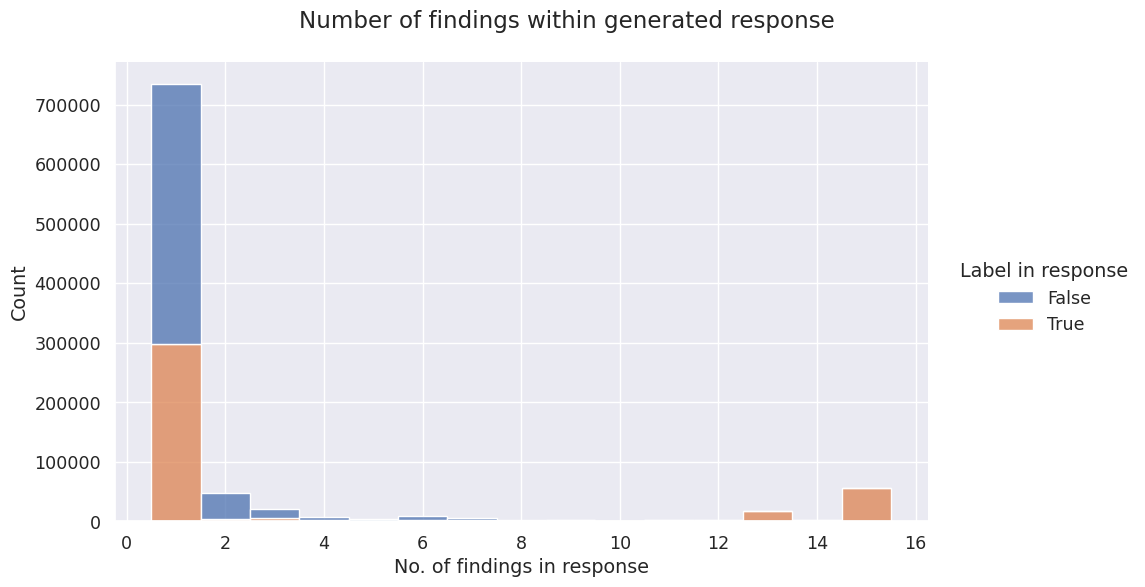

In [19]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

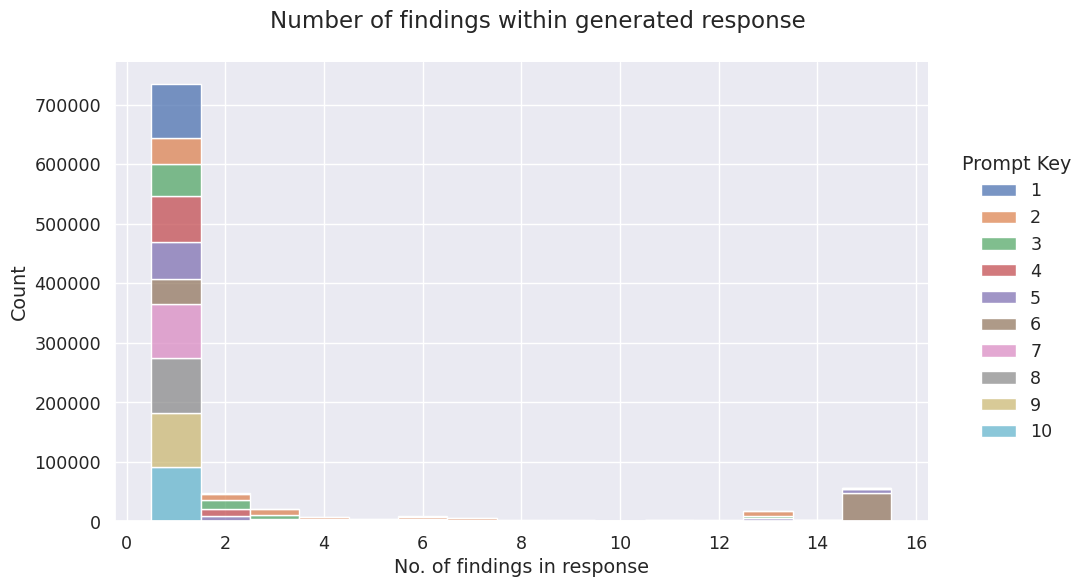

In [21]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="prompt_key",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

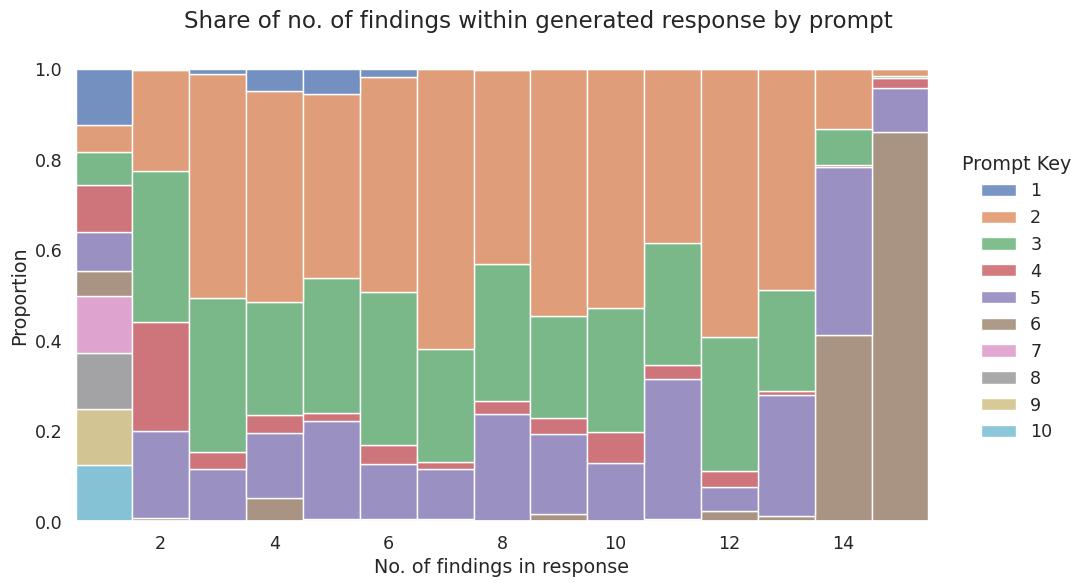

In [22]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="prompt_key",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Prompt Key")
g.figure.suptitle("Share of no. of findings within generated response by prompt")
g.tight_layout()
plt.show()

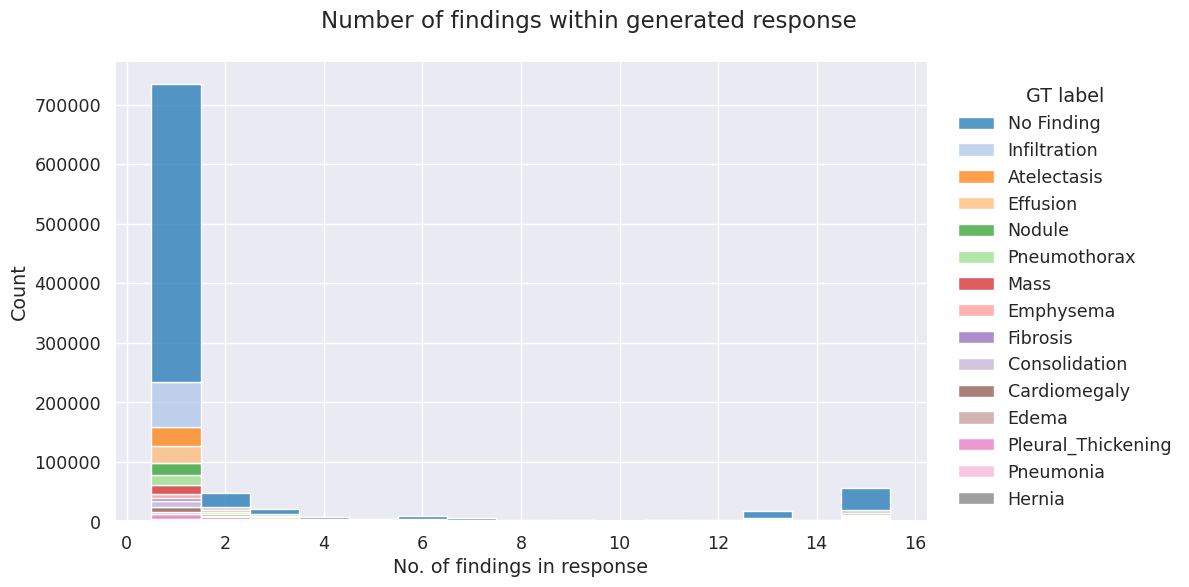

In [23]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Number of findings within generated response")
g.tight_layout()
plt.show()

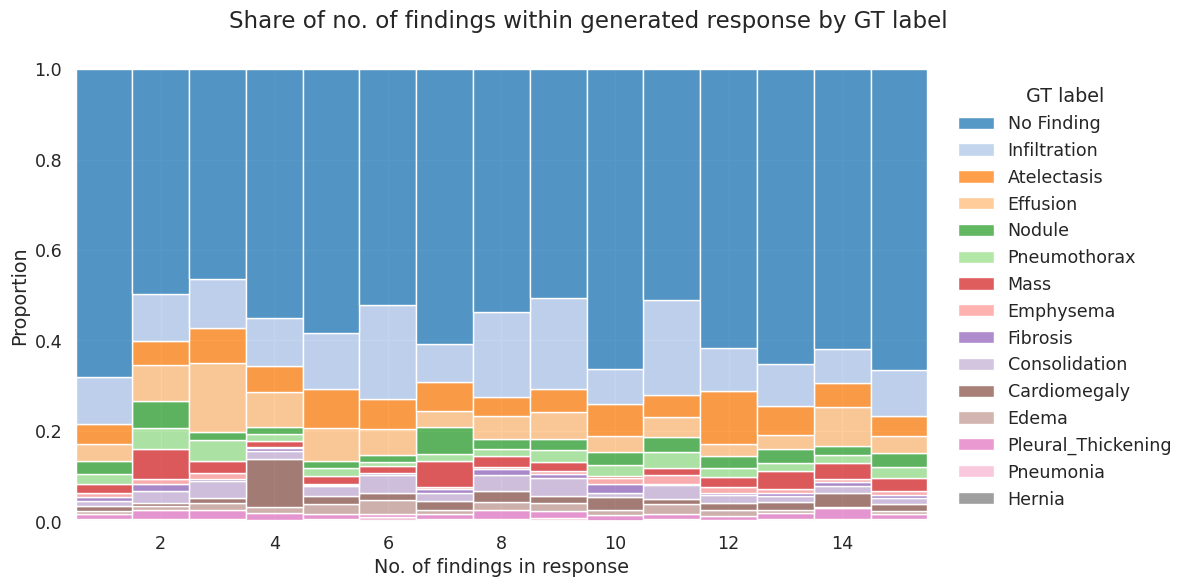

In [24]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    hue="finding_labels",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="GT label")
g.figure.suptitle("Share of no. of findings within generated response by GT label")
g.tight_layout()
plt.show()

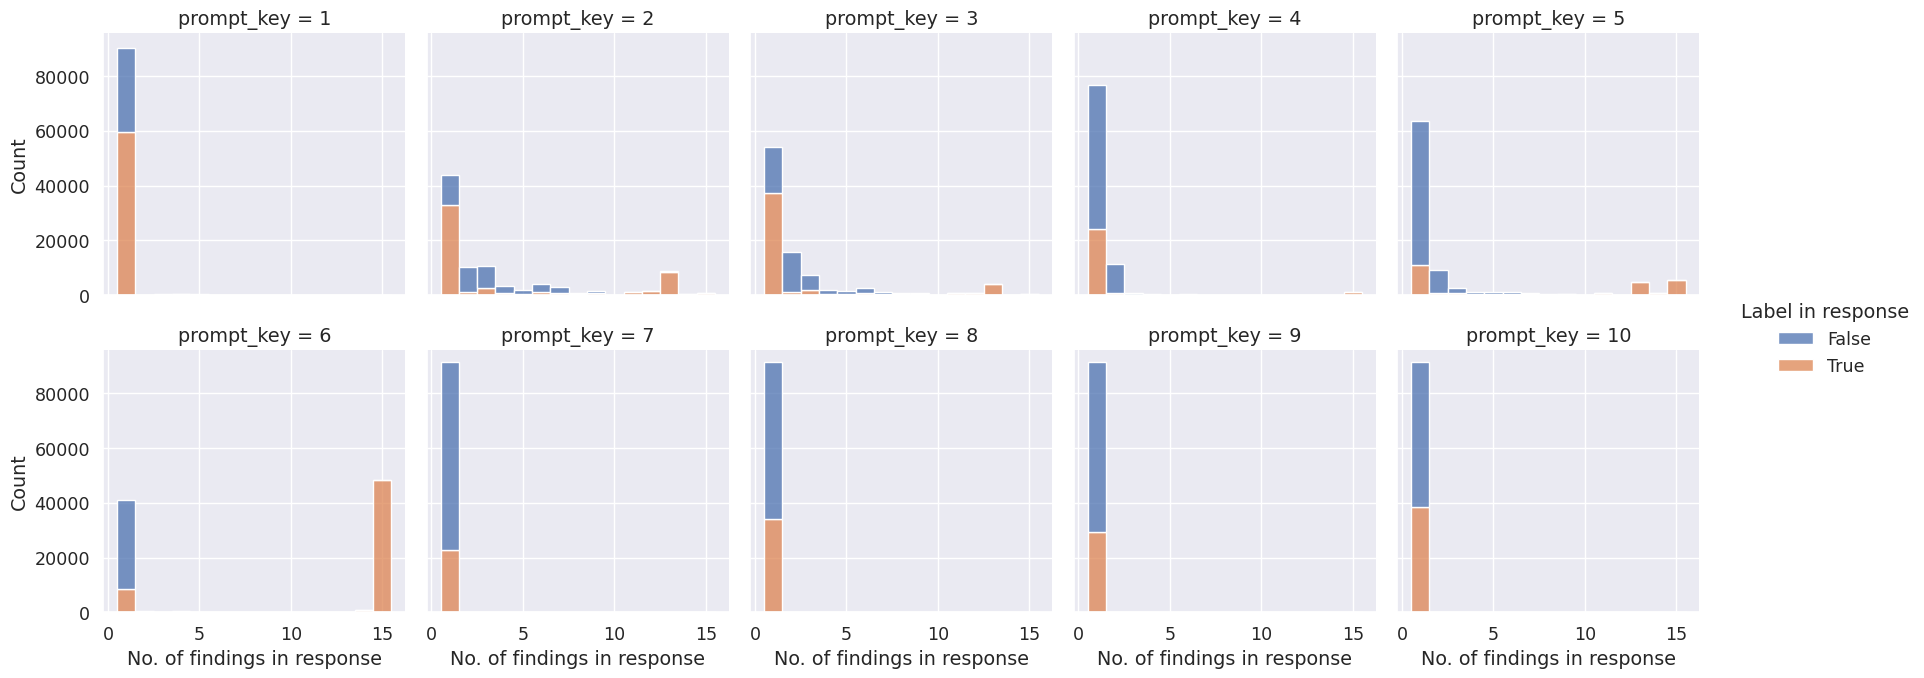

In [25]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    # palette="tab20",
)

g.set_axis_labels(x_var="No. of findings in response")
sns.move_legend(g, "right", title="Label in response")
g.tight_layout()
plt.show()

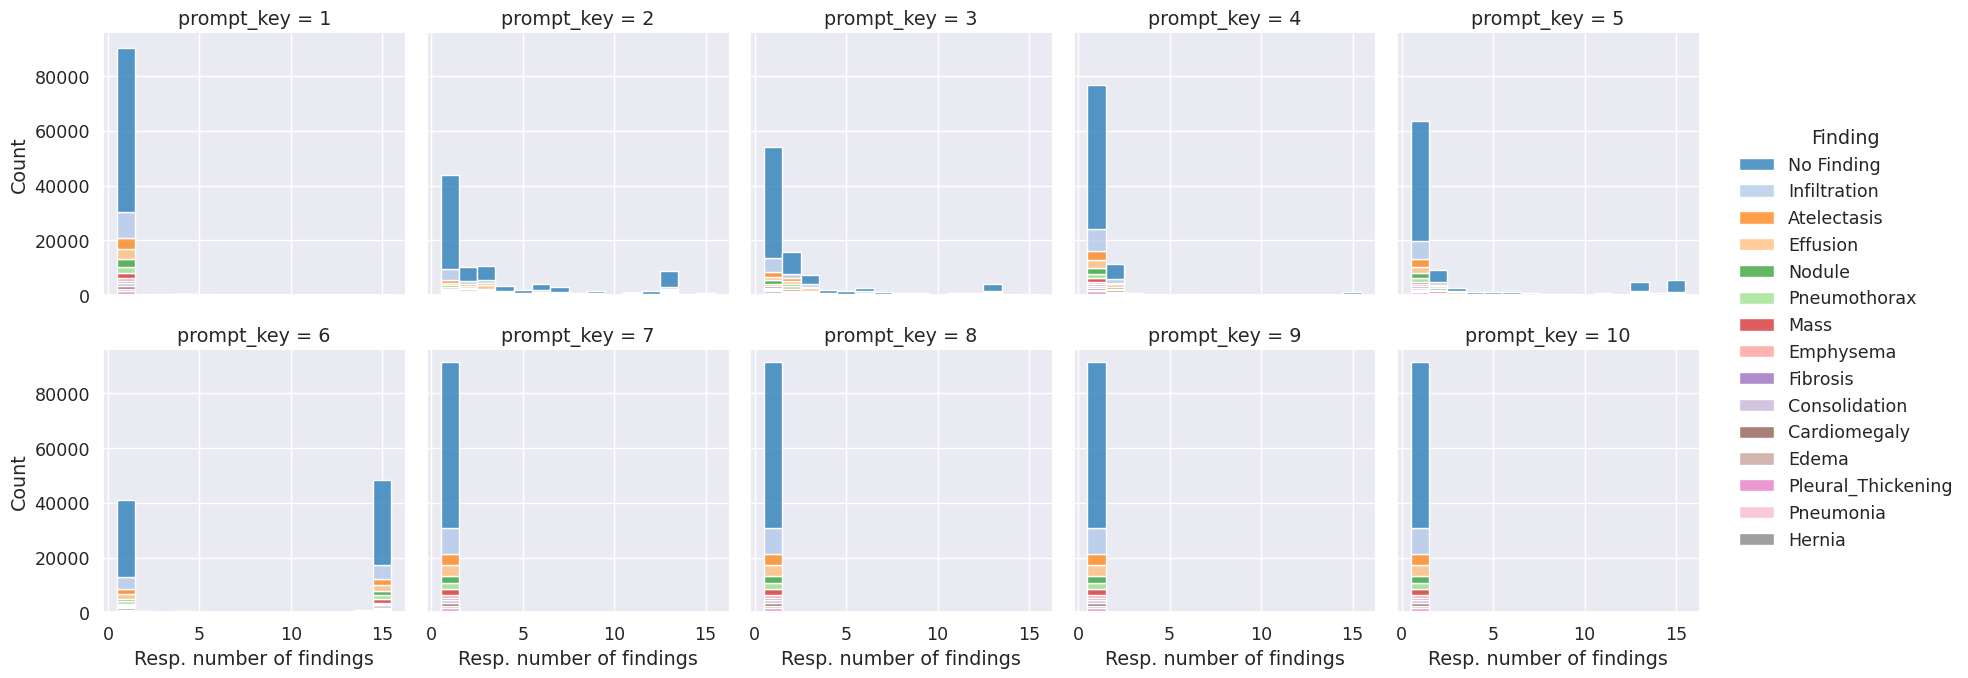

In [26]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="response_num_findings_grouped",
    col="prompt_key",
    col_wrap=5,
    height=3.5,
    hue="finding_labels",
    multiple="stack",
    discrete=True,
    palette="tab20",
)

g.set_axis_labels(x_var="Resp. number of findings")
g.legend.set_title("Finding")
g.tight_layout()
plt.show()

##### Histogram on `prompt_key`


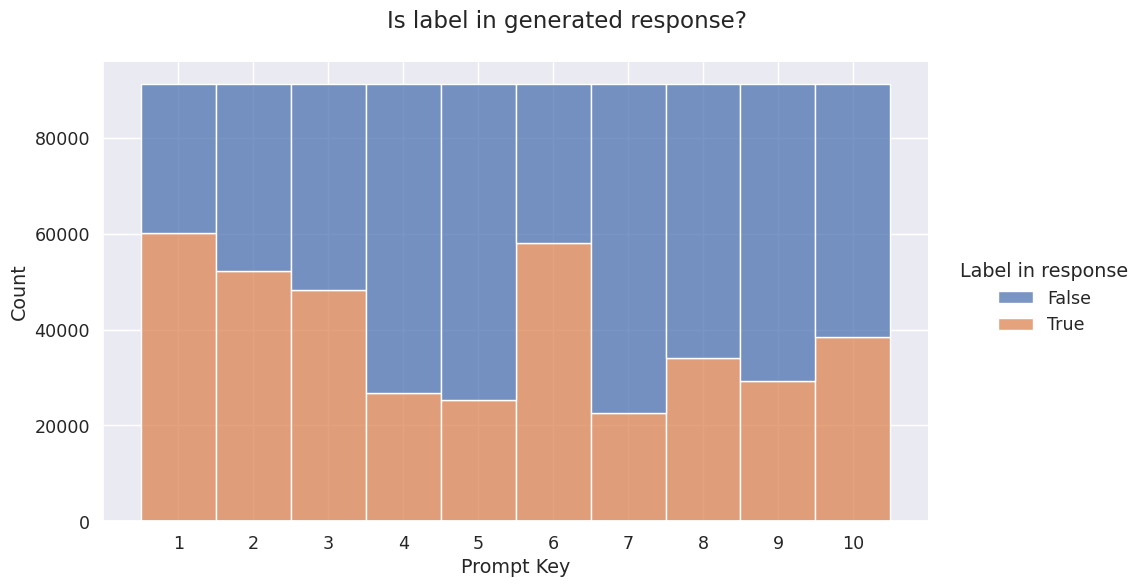

In [27]:
sns.set_theme(context="notebook", style="darkgrid", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="stack",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Is label in generated response?")
g.tight_layout()
plt.show()

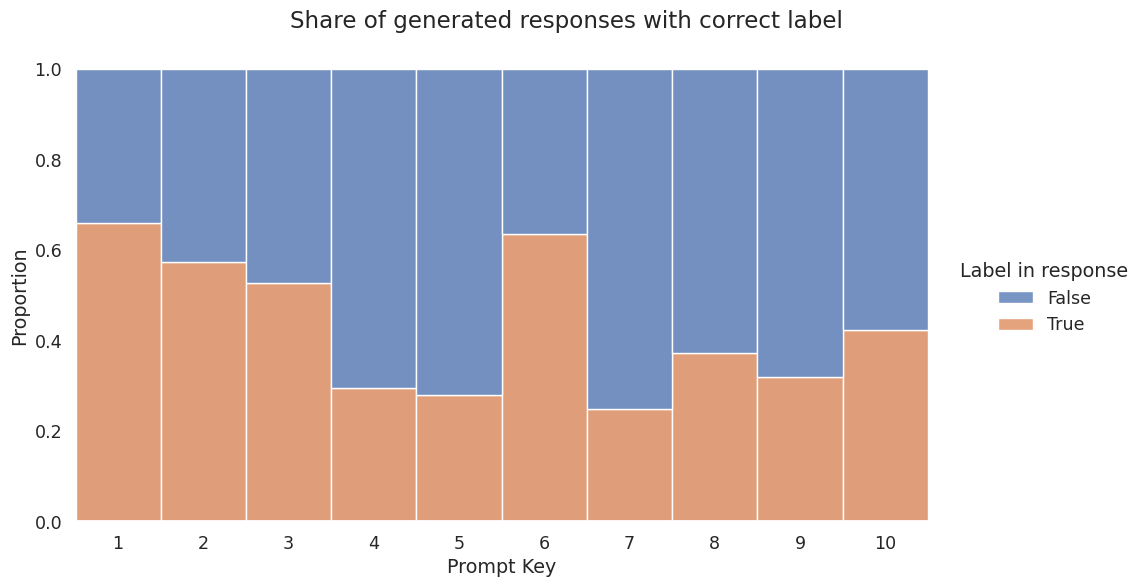

In [28]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="label_in_response",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(1, 0.5), title="Label in response")
g.figure.suptitle("Share of generated responses with correct label")
g.tight_layout()
plt.show()

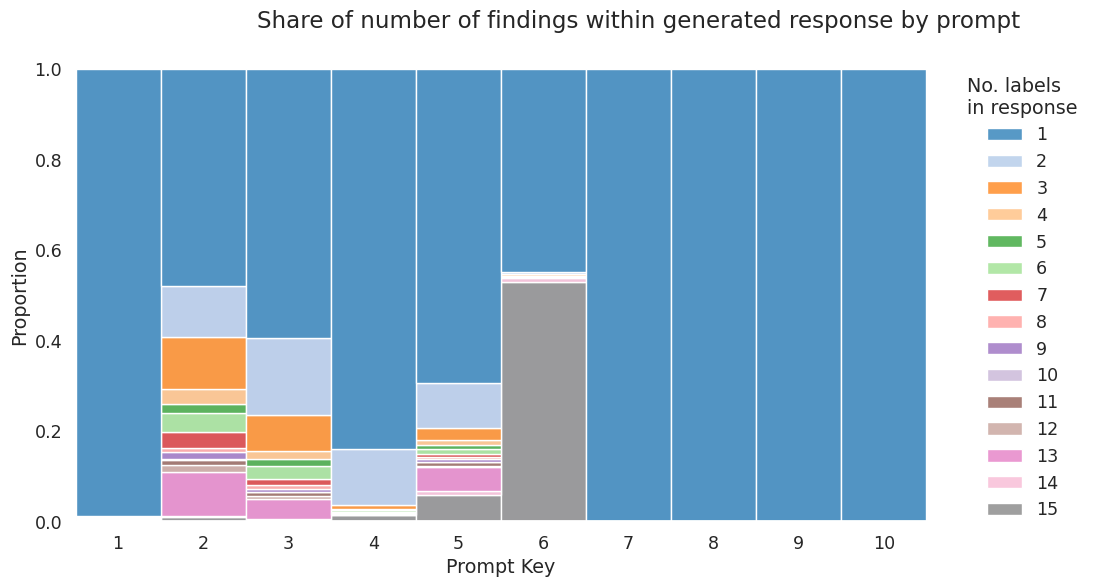

In [29]:
sns.set_theme(context="notebook", style="dark", font_scale=1.15)

g = sns.displot(
    data=results,
    x="prompt_key",
    hue="response_num_findings_grouped",
    multiple="fill",
    discrete=True,
    aspect=GOLDEN,
    height=6,
    palette="tab20",
)

g.set_axis_labels(x_var="Prompt Key", y_var="Proportion")
sns.move_legend(g, "center right", bbox_to_anchor=(0.85, 0.5), title="No. labels\nin response")
g.figure.suptitle("Share of number of findings within generated response by prompt")
g.tight_layout()
plt.show()

##### Heatmaps


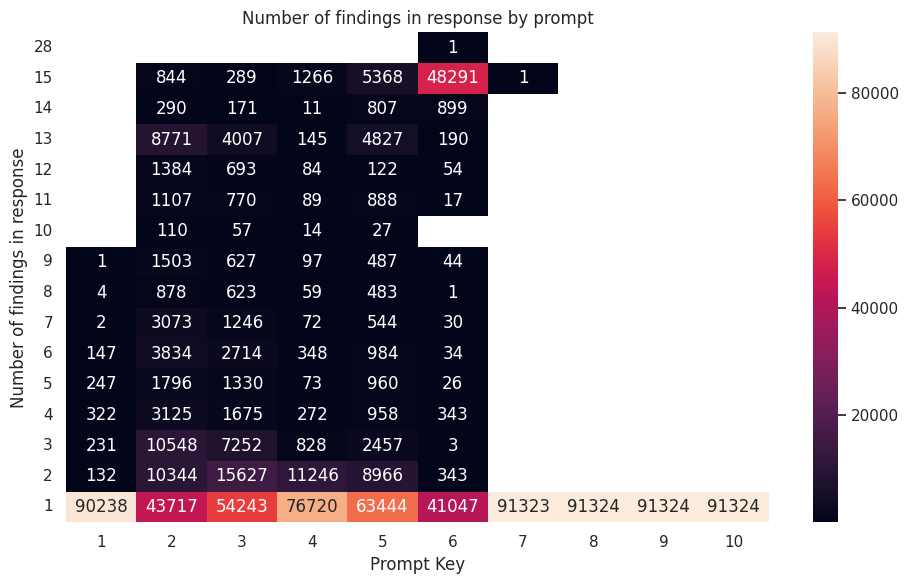

In [30]:
sns.set_theme(style="white")

plotdf = (
    results.groupby(["prompt_key", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="prompt_key", index="response_num_findings", values=0)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 6, 6))
ax = sns.heatmap(plotdf, annot=True, fmt=".0f")
ax.set(title="Number of findings in response by prompt", xlabel="Prompt Key", ylabel="Number of findings in response")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

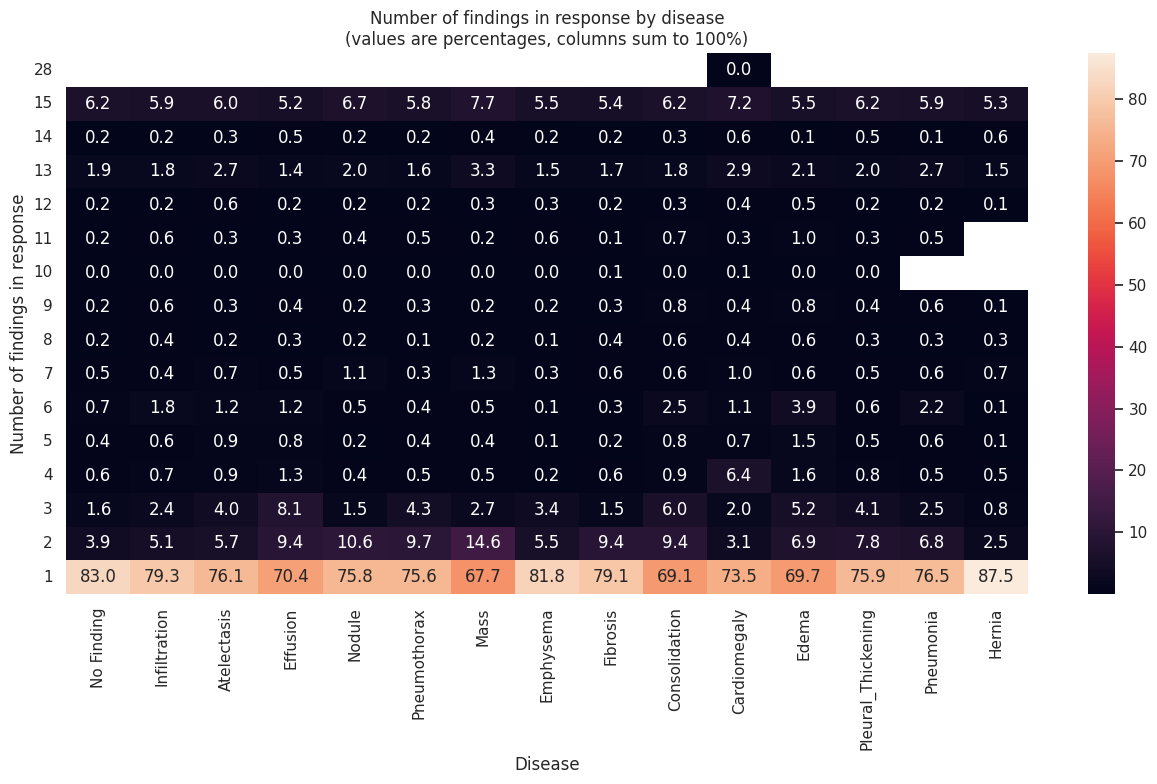

In [31]:
sns.set_theme(style="white", font_scale=1)

plotdf = (
    results.groupby(["finding_labels", "response_num_findings"], observed=True)
    .size()
    .reset_index()
    .pivot(columns="finding_labels", index="response_num_findings", values=0)
    .transform(lambda x: (x / x.sum()) * 100)
    .iloc[::-1]
)

plt.figure(figsize=(GOLDEN * 8, 8))
ax = sns.heatmap(plotdf, annot=True, fmt=".1f")
ax.set(
    title="Number of findings in response by disease\n(values are percentages, columns sum to 100%)",
    xlabel="Disease",
    ylabel="Number of findings in response",
)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()